Modern networks generate high-dimensional traffic data that can be used to detect intrusions and cyber-attacks.
In this project, we use the MachineLearningCVE dataset (MachineLearningCSV.zip)— a labeled network-traffic dataset containing both benign traffic and multiple attack types.

The **goal** is to build a **multi-class attack classifier**, evaluate multiple supervised models, compare their performance, and explore the effect of feature engineering and hyperparameter tuning.

In [ ]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# plotting style
sns.set(style='whitegrid', context='notebook')

# Task 1 — Load and Inspect the Dataset
1. Load all CSV files from the provided ZIP archive.

2. Concatenate them into a single DataFrame.

3. Display:

    - Shape of the dataset

    - List of features

    - Value counts for all attack types

4. Convert attack labels into **attack families** (multi-class target).

👉 <span style="color: white;">**Deliverable: A summary of the dataset, sample rows, and label distribution plot.**</span>


In [ ]:
#files = glob.glob(r"C:\Users\Clere\Documents\ITDS\MachineLearningCSV\*csv")
files = glob.glob('*csv')
df = pd.concat((pd.read_csv(f, nrows=100000) for f in files), ignore_index=True)


In [ ]:
print('Shape of dataset', df.shape)
df.info(verbose=False, memory_usage="deep")

Shape of dataset (800000, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 79 entries,  Destination Port to  Label
dtypes: float64(24), int64(54), object(1)
memory usage: 518.2 MB


In [ ]:
%whos

Variable                    Type         Data/Info
--------------------------------------------------
KMeans                      ABCMeta      <class 'sklearn.cluster._kmeans.KMeans'>
LogisticRegression          type         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
PCA                         ABCMeta      <class 'sklearn.decomposition._pca.PCA'>
Pipeline                    ABCMeta      <class 'sklearn.pipeline.Pipeline'>
RandomForestClassifier      ABCMeta      <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SequentialFeatureSelector   ABCMeta      <class 'sklearn.feature_s<...>quentialFeatureSelector'>
SimpleImputer               type         <class 'sklearn.impute._base.SimpleImputer'>
StandardScaler              type         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
StratifiedKFold             ABCMeta      <class 'sklearn.model_sel<...>._split.StratifiedKFold'>
col                         str           Idle Min
cross_val_score             functio

In [ ]:
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

In [ ]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 79 entries,  Destination Port to  Label
dtypes: float32(9), float64(15), int16(6), int32(27), int64(2), int8(19), object(1)
memory usage: 279.4 MB


In [ ]:
df.columns = (
    df.columns.str.strip().str.lower()
      .str.replace(r'\s+', '_', regex=True)
      .str.replace('[^a-z0-9_]', '', regex=True)
)
df.sample(3)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
122944,49689,3,2,0,37,0,37,0,18.5,26.162951,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
584436,53,320,2,2,86,198,43,43,43.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
390463,1077,44,1,1,2,6,2,2,2.0,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan


In [ ]:
print('List of Features: \n')
print(df.columns.to_list())

List of Features: 

['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytess', 'flow_packetss', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packetss', 'bwd_packetss', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 'cwe_flag_count',

In [ ]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 79 entries, destination_port to label
dtypes: float32(9), float64(15), int16(6), int32(27), int64(2), int8(19), object(1)
memory usage: 279.4 MB


In [ ]:
# Summary of Dataset
df.sample(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
401006,53,1052,2,2,60,264,30,30,30.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
230534,53,60486,1,1,63,121,63,63,63.00000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
324653,53,157,2,2,46,46,23,23,23.00000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
633399,53,48227,2,2,80,248,40,40,40.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
450624,443,6357597,7,4,617,153,517,0,88.14286,189.988968,...,20,941044.0,0.0,941044,941044,5416552.0,0.0,5416552,5416552,BENIGN


In [ ]:
print("\nAttack Type Distribution:")
print(df['label'].value_counts())


Attack Type Distribution:
label
BENIGN                        680098
DDoS                           61194
DoS Hulk                       24364
PortScan                       12488
FTP-Patator                     7921
DoS slowloris                   5796
DoS Slowhttptest                5499
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Bot                              442
Web Attack � Sql Injection        21
Infiltration                      18
Name: count, dtype: int64


In [ ]:
df['label'].unique()

array(['BENIGN', 'Bot', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'PortScan', 'DDoS', 'Infiltration', 'Web Attack � Brute Force',
       'Web Attack � XSS', 'Web Attack � Sql Injection', 'FTP-Patator'],
      dtype=object)

In [ ]:
df['label'] = (
    df['label']
        .str.replace('�', '', regex=False)    # replace unknown char
        .str.strip()                           # remove leading/trailing spaces
        .str.replace(r'\s+', '_', regex=True)  # spaces → underscore
        .str.lower()                           # lowercase
)

In [ ]:
df['label'].unique()

array(['benign', 'bot', 'dos_slowloris', 'dos_slowhttptest', 'dos_hulk',
       'portscan', 'ddos', 'infiltration', 'web_attack_brute_force',
       'web_attack_xss', 'web_attack_sql_injection', 'ftp-patator'],
      dtype=object)

In [ ]:
attack_family_map = {'benign':'benign',
    # DoS family
    'dos_slowloris': 'dos', 'dos_slowhttptest': 'dos', 'dos_hulk': 'dos', 'dos_goldeneye': 'dos',
    # DDoS
    'ddos': 'ddos',
    # PortScan
    'portscan':'scan',
    # Bot
    'bot':'botnet',
    # Infiltration
    'infiltration':'infiltration',
    # Web attacks (all variants)
    'web_attack_brute_force': 'web_attack', 'web_attack_xss': 'web_attack', 'web_attack_sql_injection': 'web_attack',
    # Brute force (Patator tools)
    'ftp-patator': 'bruteforce', 'ssh-patator': 'bruteforce',
    # Heartbleed
    'heartbleed': 'heartbleed'
}
df['attack_family'] = df['label'].map(attack_family_map)

In [ ]:
df[['label', 'attack_family']].sample(7)

,label,attack_family
437034,ddos,ddos
713656,ftp-patator,bruteforce
275927,dos_hulk,dos
489401,ddos,ddos
789675,benign,benign
205191,benign,benign
352582,benign,benign


In [ ]:
df['attack_family'].value_counts()

,count
attack_family,
benign,680098
ddos,61194
dos,35659
scan,12488
bruteforce,7921
web_attack,2180
botnet,442
infiltration,18


In [ ]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytess', 'flow_packetss',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packetss', 'bwd_packetss',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_count'

In [ ]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 80 entries, destination_port to attack_family
dtypes: float32(9), float64(15), int16(6), int32(27), int64(2), int8(19), object(2)
memory usage: 321.1 MB


In [ ]:
df['attack_family'] = df['attack_family'].astype('category')
df['label'] = df['label'].astype('category')

In [ ]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 80 entries, destination_port to attack_family
dtypes: category(2), float32(9), float64(15), int16(6), int32(27), int64(2), int8(19)
memory usage: 238.8 MB


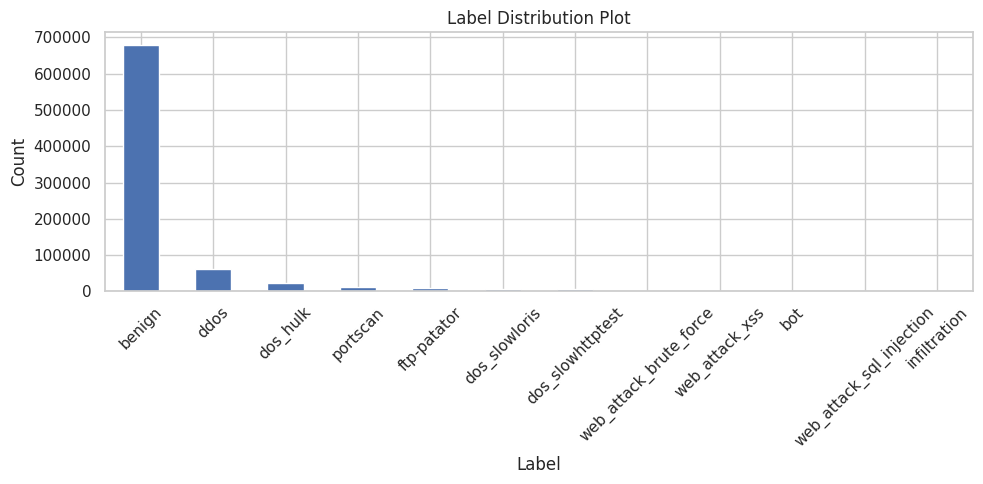

In [ ]:
plt.figure(figsize=(10,5))
df['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution Plot")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task 2 — Exploratory Data Analysis (EDA)
Perform a full EDA including:

## 2.1. Descriptive statistics
- Summary statistics (mean, median, std)

- Missing value analysis

- Outlier detection (boxplots or IQR method)

## 2.2 Univariate analysis
- Distribution of key traffic features (histograms)

- Correlation matrix, Causality analysis and heatmap

## 2.3 Multivariate analysis
- Pairplots for a subset of features

- PCA visualization (2D or 3D)

- Discussion: Are attack families separable?

👉 **Deliverable: Figures + interpretation of patterns found in the data.**

In [ ]:
# numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features count:", len(num_cols))

desc = df[num_cols].describe().T
desc['median'] = df[num_cols].median()
desc = desc[['count','mean','median','std','min','25%','50%','75%','max']]
display(desc)

Numeric features count: 78


,count,mean,median,std,min,25%,50%,75%,max
destination_port,800000.0,6.793618e+03,80.0,1.699395e+04,0.0,53.0,80.0,443.0,65534.0
flow_duration,800000.0,1.611534e+07,64951.5,3.434671e+07,-12.0,244.0,64951.5,5644842.0,119999993.0
total_fwd_packets,800000.0,1.864893e+01,2.0,1.395812e+03,1.0,2.0,2.0,6.0,219759.0
total_backward_packets,800000.0,2.244480e+01,2.0,1.857043e+03,0.0,1.0,2.0,5.0,291922.0
total_length_of_fwd_packets,800000.0,7.336446e+02,64.0,1.023700e+04,0.0,24.0,64.0,352.0,2866110.0
...,...,...,...,...,...,...,...,...,...
active_min,800000.0,1.004131e+05,0.0,7.913888e+05,0.0,0.0,0.0,0.0,107000000.0
idle_mean,800000.0,6.803449e+06,0.0,1.897958e+07,0.0,0.0,0.0,0.0,120000000.0
idle_std,800000.0,7.560719e+05,0.0,5.110099e+06,0.0,0.0,0.0,0.0,75900000.0
idle_max,800000.0,7.409509e+06,0.0,2.019854e+07,0.0,0.0,0.0,0.0,120000000.0


In [ ]:
def iqr_outlier_mask(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

outlier_counts = {c: iqr_outlier_mask(df[c].dropna()).sum() for c in num_cols}
outlier_counts = pd.Series(outlier_counts).sort_values(ascending=False)
display(outlier_counts.head(20))


,0
idle_min,185730
idle_max,185730
idle_mean,185730
active_mean,184922
active_max,184922
active_min,184922
bwd_iat_max,183235
bwd_iat_mean,178635
bwd_iat_total,177277
total_length_of_bwd_packets,176445


In [ ]:
x_cols = ['fwd_iat_mean', 'fwd_iat_max', 'fwd_iat_total', 'fwd_packet_length_max',
       'fwd_packet_length_std', 'fwd_iat_std', 'packet_length_variance',
       'bwd_packet_length_std', 'bwd_packet_length_max', 'destination_port',
       'max_packet_length', 'subflow_bwd_bytes', 'total_length_of_bwd_packets',
       'flow_iat_std', 'bwd_iat_std']

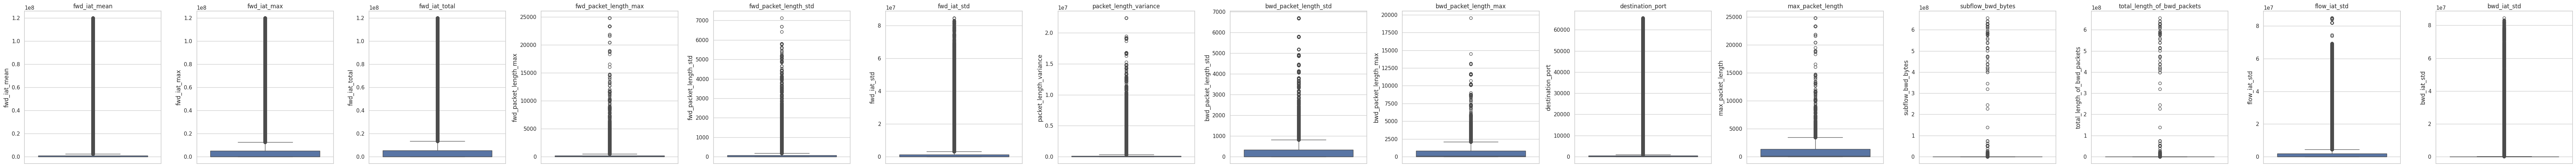

In [ ]:
n_cols = len(x_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))

for idx, col in enumerate(x_cols):
    if n_cols > 1:
        ax = axes[idx]
    else:
        ax = axes

    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'{col}')

plt.tight_layout()
plt.show()

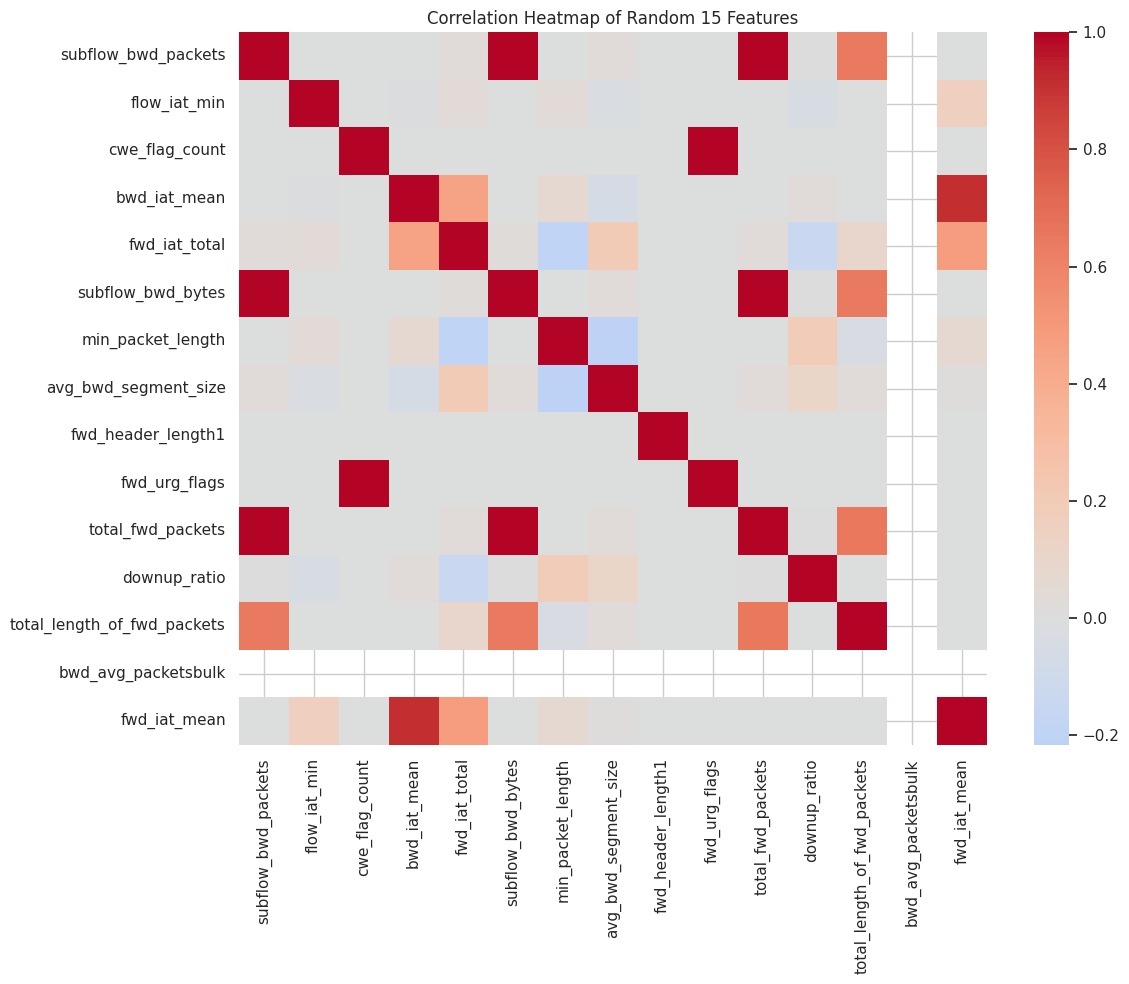

In [ ]:
n_features = 15
numeric_cols = df.select_dtypes(include=[np.number]).columns
random_features = np.random.choice(numeric_cols, size=n_features, replace=False)

df_subset = df[random_features]
correlation = df_subset.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Random {} Features'.format(n_features))
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytess', 'flow_packetss',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packetss', 'bwd_packetss',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_count'

In [ ]:
drop_features = ['fwd_avg_bytesbulk','fwd_avg_packetsbulk',
                'fwd_avg_bulk_rate','bwd_avg_bytesbulk',
                 'bwd_avg_packetsbulk','bwd_avg_bulk_rate',
                 'subflow_fwd_packets','subflow_fwd_bytes',
                 'subflow_bwd_packets','subflow_bwd_bytes',
                 'fwd_header_length1','average_packet_size',
                 'avg_fwd_segment_size','avg_bwd_segment_size','label'
]


In [ ]:
df.drop(columns=drop_features, inplace=True)

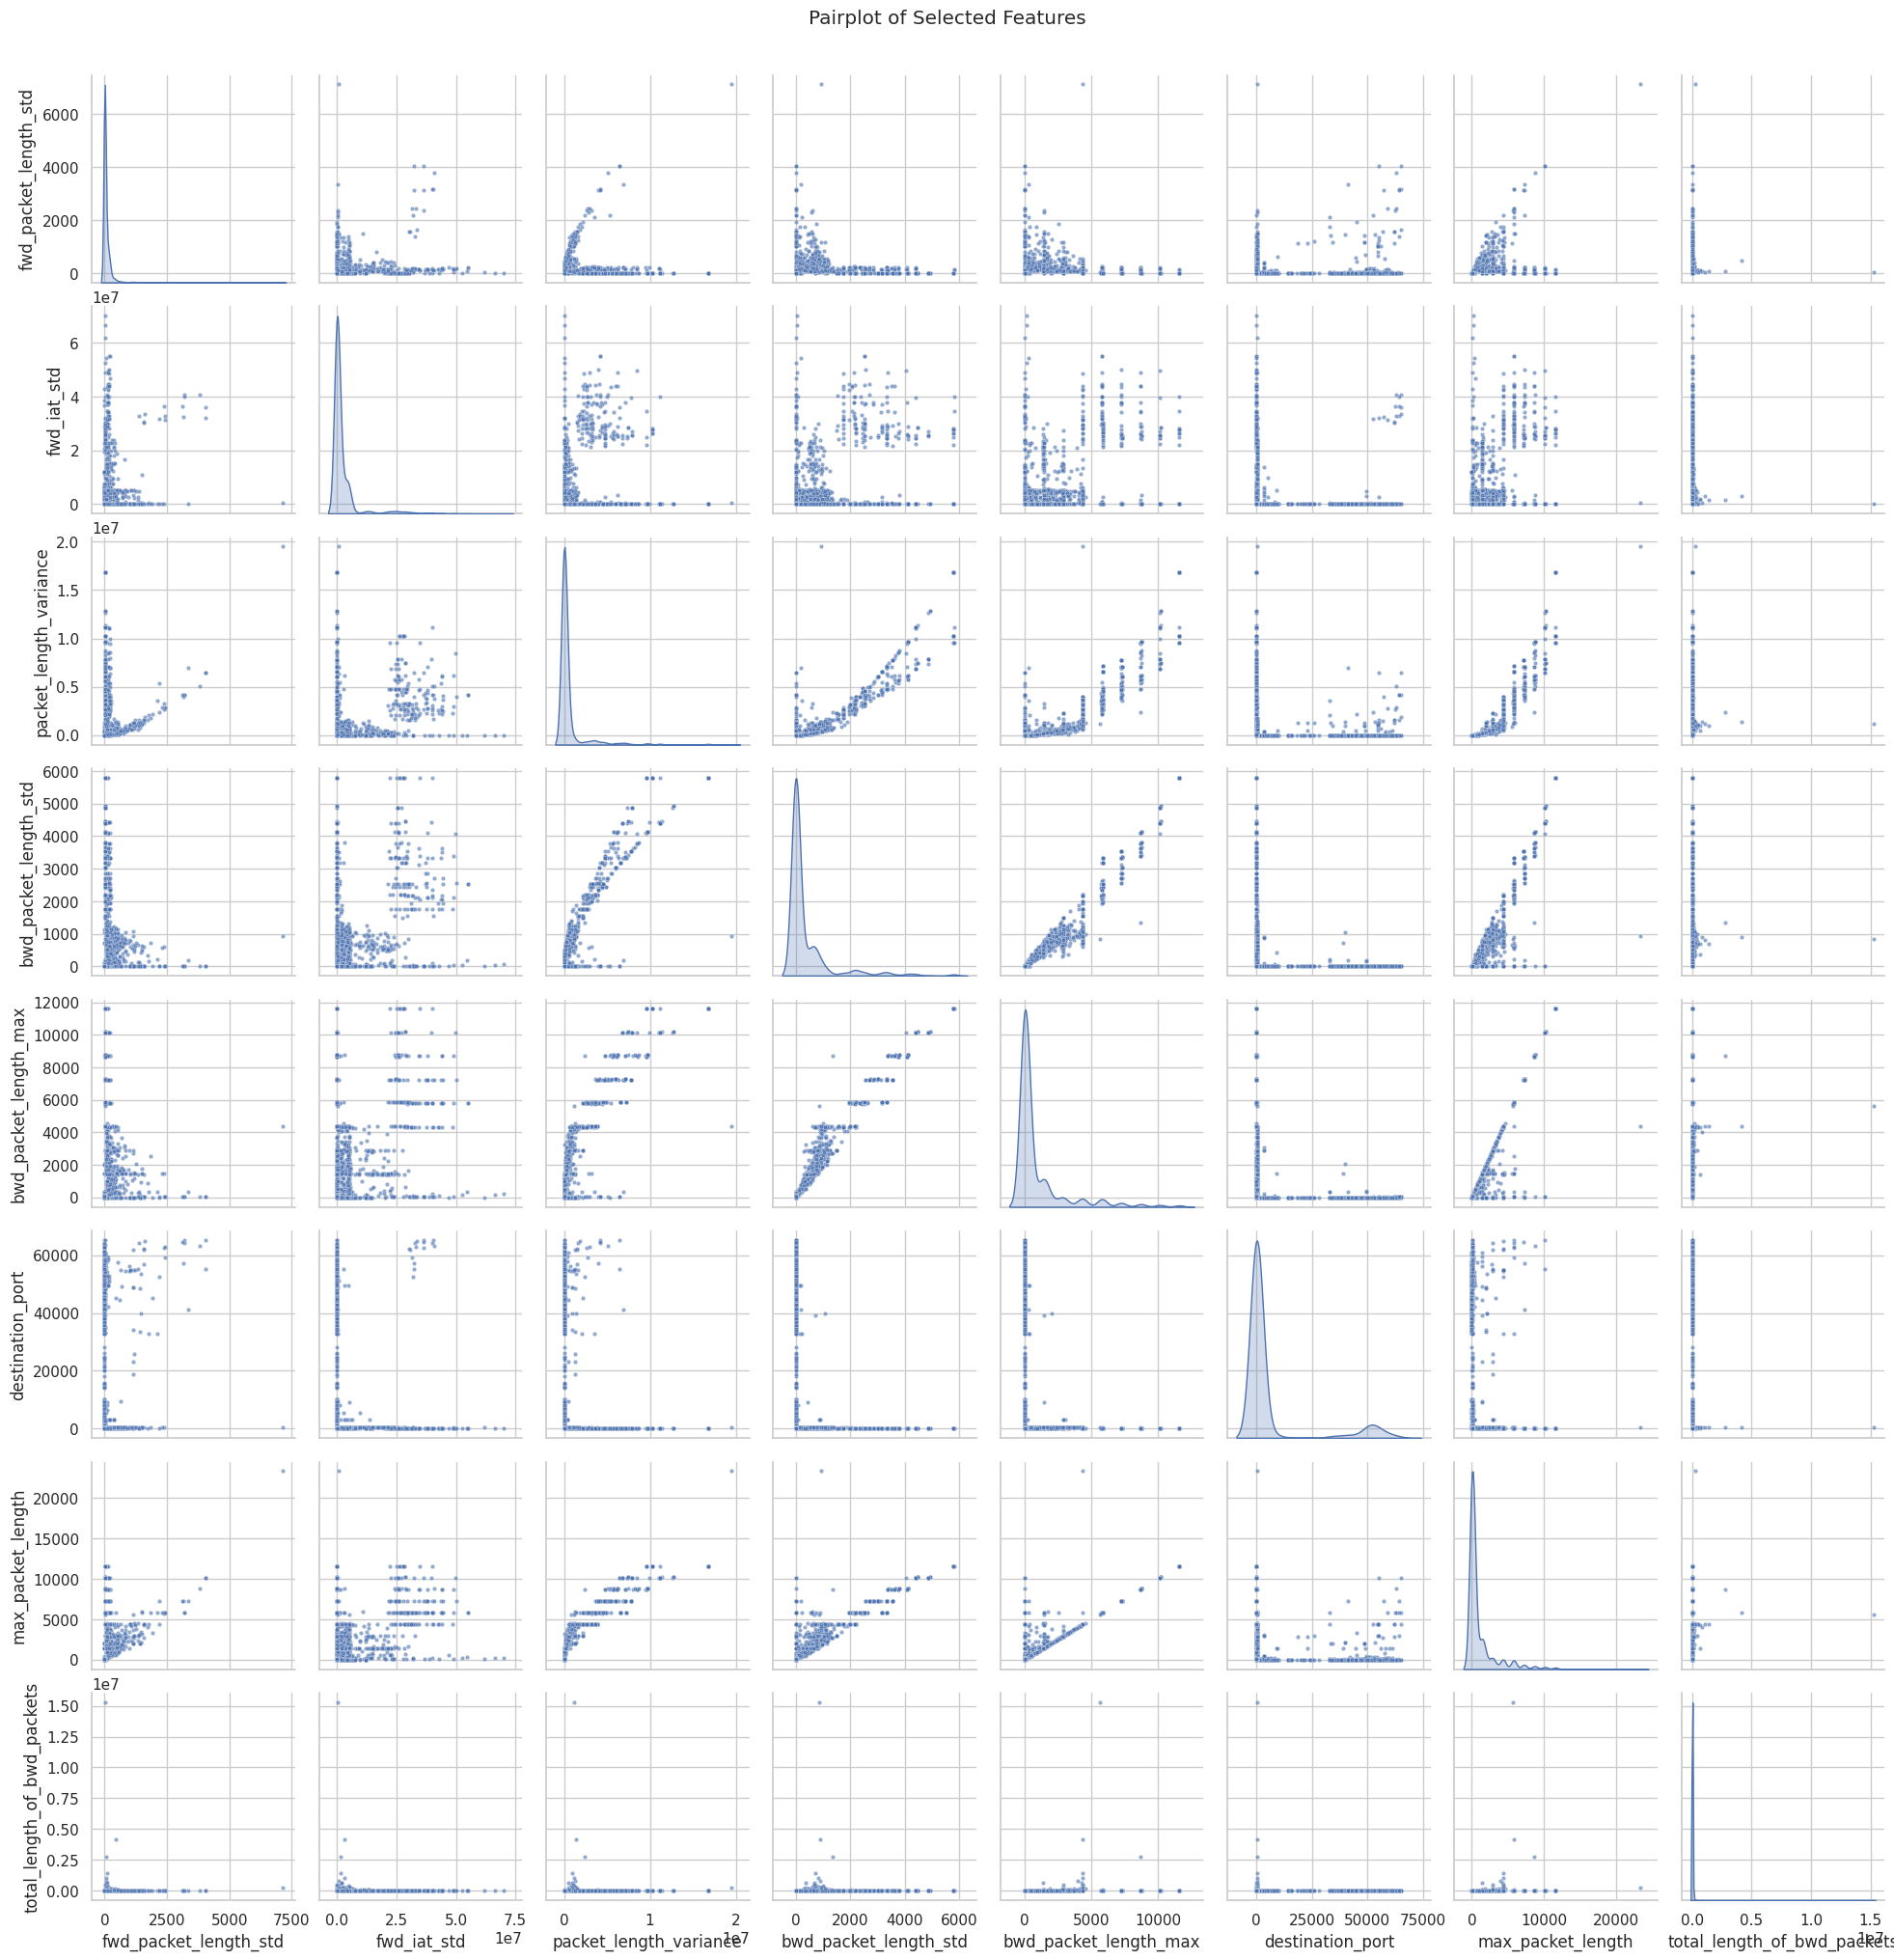

In [ ]:
# Multivariate Analysis (Pairplots)
sample_for_pairplot = df.sample(min(5000, len(df)), random_state=42)
selected_features_for_pairplot = ['fwd_packet_length_std', 'fwd_iat_std', 'packet_length_variance',
       'bwd_packet_length_std', 'bwd_packet_length_max', 'destination_port',
       'max_packet_length',  'total_length_of_bwd_packets']

sns.pairplot(sample_for_pairplot[selected_features_for_pairplot], hue=None, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10})
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   destination_port             800000 non-null  int32   
 1   flow_duration                800000 non-null  int32   
 2   total_fwd_packets            800000 non-null  int32   
 3   total_backward_packets       800000 non-null  int32   
 4   total_length_of_fwd_packets  800000 non-null  int32   
 5   total_length_of_bwd_packets  800000 non-null  int32   
 6   fwd_packet_length_max        800000 non-null  int16   
 7   fwd_packet_length_min        800000 non-null  int16   
 8   fwd_packet_length_mean       800000 non-null  float32 
 9   fwd_packet_length_std        800000 non-null  float32 
 10  bwd_packet_length_max        800000 non-null  int16   
 11  bwd_packet_length_min        800000 non-null  int16   
 12  bwd_packet_length_mean       800000 non-null

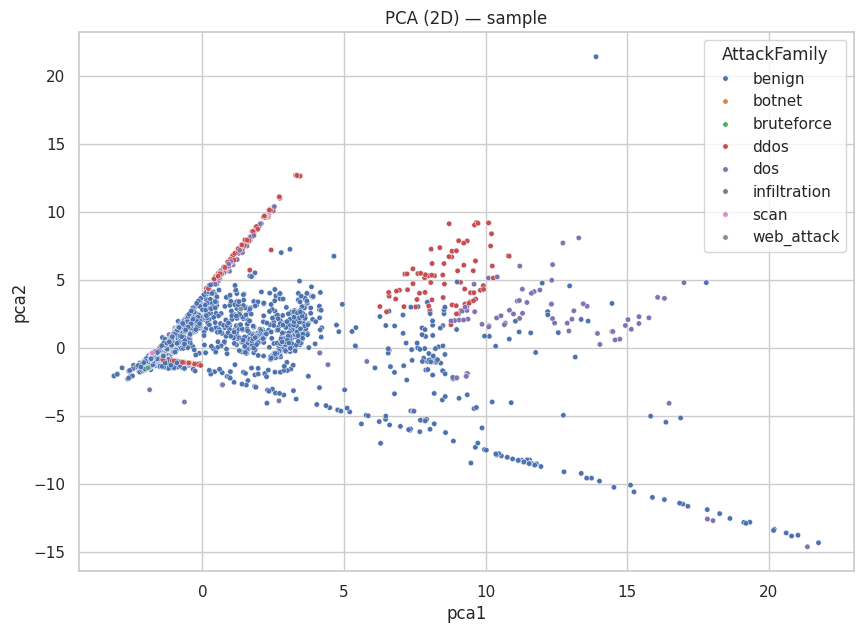

In [ ]:
# PCA 2D for visualization
numeric_df = df.select_dtypes(include=[np.number]).copy()
clean_numeric = numeric_df.replace([np.inf,-np.inf], np.nan).fillna(numeric_df.median())
scaler = StandardScaler()
scaled = scaler.fit_transform(clean_numeric)
pca2d = PCA(n_components=2, random_state=42)
pca_data = pca2d.fit_transform(scaled)

pca_df = pd.DataFrame({'pca1': pca_data[:,0], 'pca2': pca_data[:,1], 'AttackFamily': df['attack_family']})
plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df.sample(min(5000,len(pca_df)), random_state=42),
                x='pca1', y='pca2', hue='AttackFamily', s=15)
plt.title("PCA (2D) — sample")
plt.show()

# Task 3 — Feature Engineering
Perform feature transformations including:

1. Cleaning (remove/replace ∞ values, handle NaN)

2. Scaling (StandardScaler or MinMaxScaler)

3. Feature selection:

    - Sequential Forward Selection

    - Sequential Backward Selection

    - Bidirectional Selection

4. Dimensionality reduction:

    - PCA (retain 95% variance or fixed k)

👉 **Deliverable: Explain and justify your engineered feature set.**

In [ ]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 65 entries, destination_port to attack_family
dtypes: category(1), float32(6), float64(15), int16(6), int32(23), int64(1), int8(13)
memory usage: 206.0 MB


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')

df[num_cols] = imputer.fit_transform(df[num_cols])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

In [ ]:
df_scaled.sample(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
46183,0.050188,2.583333e-07,0.000055,0.000000,0.000082,0.000000e+00,0.000725,0.008717,0.003283,0.0,...,0.000056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355227,0.807993,1.491667e-06,0.000005,0.000003,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547715,0.000809,2.569583e-04,0.000005,0.000007,0.000031,5.248278e-07,0.001773,0.021308,0.008024,0.0,...,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363866,0.000809,2.700000e-06,0.000005,0.000007,0.000029,2.685166e-07,0.001652,0.019855,0.007477,0.0,...,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674141,0.006760,8.833333e-07,0.000005,0.000000,0.000004,0.000000e+00,0.000242,0.002906,0.001094,0.0,...,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_scaled = pd.DataFrame(df_scaled, columns=df_scaled.columns)
model = LogisticRegression(max_iter=200, n_jobs=-1, penalty='l2')

LABEL_ENCODER = LabelEncoder()
y = LABEL_ENCODER.fit_transform(df['attack_family'])


In [ ]:
# Forward Selection
sfs = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select=5,
    direction='forward',
    cv=3
)
sfs.fit(df_scaled, y)
forward_features = df_scaled.columns[sfs.get_support()]

KeyboardInterrupt: 

In [ ]:
# Backward Selection
sbs = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select=5,
    direction='backward',
    cv=3,
    n_jobs = -1
)
sbs.fit(df_scaled, y)
backward_features = df_scaled.columns[sbs.get_support()]

In [ ]:
# Bidirectional Selection
bi = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select=5,
    direction='both',
    cv=3,
    n_jobs = -1
)
bi.fit(df_scaled, y)
bidirectional_features = df_scaled.columns[bi.get_support()]

In [ ]:
pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(df_scaled)

print(f"PCA Components (95% variance): {pca_95.n_components_}")


print("\n FEATURE SELECTION RESULTS ")
print("Forward Selection Features:")
print(list(forward_features))

print("\nBackward Selection Features:")
print(list(backward_features))

print("\nBidirectional Selection Features:")
print(list(bidirectional_features))

print("\nPCA Shapes:")
print("X_pca_95:", X_pca_95.shape)

# Task 4 — Multi-Class Classification Models
Implement at least three different classifiers, such as:

- Decision Tree
- Naive Bayes
- k-NN

Train each model on the same training set and evaluate with:

- Accuracy
- Macro-F1 score
- Per-class recall

👉 **Deliverable: A comparison table and discussion of the strengths and weaknesses of each model.**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca95, y, test_size=0.3, random_state=SEED, stratify=y_le)
classifiers = {
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "NaiveBayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average='macro')
    }
results_df = pd.DataFrame(results).T
display(results_df)

#Per-Class Recall
print("Per-class recall and full classification report:")
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    print(f"\n--- {name} ---")
    # Get unique labels present in y_test
    unique_labels = np.unique(y_test)
    # Get corresponding target names
    unique_target_names = LABEL_ENCODER.inverse_transform(unique_labels)
    print(classification_report(y_test, y_pred, labels=unique_labels, target_names=unique_target_names))

# Task 5 — Monte-Carlo Cross-Validation (MCCV)
Set up Monte-Carlo CV:

1. Choose number of iterations (e.g., 100, 200).
2. For each iteration:
    - Random split (train/test proportions like 70%/30%)
    - Train classifier
    - Record metrics (accuracy, macro-F1, per-class recall)
      
3. For each model:

    - Compute mean ± standard deviation for each metric

👉 **Deliverable:**
- **Plots showing how model performance varies across MCCV iterations.**
- **A statistical comparison of model stability.**

In [ ]:
mccv_results = {name: {"accuracy": [], "macro_f1": []} for name in classifiers.keys()}
X_mccv = X_pca95
y_mccv = y
sample_idx = np.random.choice(len(X_mccv), min(MCCV_SAMPLE, len(X_mccv)), replace=False)
X_mccv = X_mccv[sample_idx]
y_mccv = np.array(y_mccv)[sample_idx]

for i in range(MCCV_ITER):
    X_tr, X_te, y_tr, y_te = train_test_split(X_mccv, y_mccv, test_size=0.3, stratify=y_mccv)
    for name, clf in classifiers.items():
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        mccv_results[name]["accuracy"].append(accuracy_score(y_te, y_pred))
        mccv_results[name]["macro_f1"].append(f1_score(y_te, y_pred, average='macro'))

# MCCV summary
for name in classifiers.keys():
    print(f"{name}: Accuracy {np.mean(mccv_results[name]['accuracy']):.3f} ± {np.std(mccv_results[name]['accuracy']):.3f}, "
          f"Macro F1 {np.mean(mccv_results[name]['macro_f1']):.3f} ± {np.std(mccv_results[name]['macro_f1']):.3f}")


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Accuracy over MCCV iterations
for name, metrics in mccv_results.items():
    axes[0].plot(metrics['accuracy'], label=name)
axes[0].set_title('Accuracy Across MCCV Iterations')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Macro F1 over MCCV iterations
for name, metrics in mccv_results.items():
    axes[1].plot(metrics['macro_f1'], label=name)
axes[1].set_title('Macro F1 Across MCCV Iterations')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Macro F1')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Task 6 — Hyperparameter Tuning
Select **the best-performing model** and tune it using:

***Option A — GridSearchCV***

or

***Option B — RandomizedSearchCV (preferred for large spaces)***

Perform tuning within a cross-validation setup for each selected model.

👉 **Deliverable:**

- **Best hyperparameter set**

- **Comparison between base model vs tuned model**

- **Improved metrics**

In [ ]:
# RandomizedSearchCV
best_model = DecisionTreeClassifier(random_state=42)
param_dist = {
    "max_depth": [None,5,10,20],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,5],
    "criterion": ["gini","entropy"]
}
rs_cv = RandomizedSearchCV(best_model, param_distributions=param_dist,
                           n_iter=10, scoring='f1_macro', cv=3, random_state=42, n_jobs=-1, verbose=1)
rs_cv.fit(X_mccv, y_mccv)
print("Best hyperparameters:", rs_cv.best_params_)

# Compare base vs tuned
y_pred_base = best_model.fit(X_mccv, y_mccv).predict(X_mccv)
y_pred_tuned = rs_cv.best_estimator_.predict(X_mccv)
print(f"Base: Accuracy {accuracy_score(y_mccv,y_pred_base):.3f}, Macro F1 {f1_score(y_mccv,y_pred_base,average='macro'):.3f}")
print(f"Tuned: Accuracy {accuracy_score(y_mccv,y_pred_tuned):.3f}, Macro F1 {f1_score(y_mccv,y_pred_tuned,average='macro'):.3f}")
